# 5. Forecasting

[index](../Index.ipynb) | [prev](./04.DataCollection.ipynb) | [next](./06.AnomalyDetection.ipynb)

The idea to generate a forecast for the detected objects did not exist in this project from the beginning, when the aim was to build a toy-project to use a Raspberry Pi for real time object detection.

The step above was accomplished within six months and an idea occurred to me during a student meetup in the university: Can detected objects be used as a dataset to predict object counts?

This tought has changed my perspective about the project, and since then I began to look at images as a valuable data source.

Forecasting expected object counts can be very beneficial not only for our own curiosity, but also for anomaly detection. For example, if the predicted number of people at 3PM on a weekend-day is 5 and we have already observed 15 people, then something unusual must be happening and perhaps we would like to be notified about it.

It is important to decide on the time interval for the forecast.

I have explored several intervals, including 15-minutes, 1-hour and 3-hour windows, but the 1 hour turned out to be the best choice for two reasons:
- 15 minute forecast is too noisy and it is too difficult to predict object counts with high accuracy
- 3 hour window is too large and reduces the data size too much
- 1 hour is a good trade-off

This Notebook dives into the detail of the steps taken to generate such a forecast:
- data extraction and clean up of raw images
- approach to counting objects
- more data preparation and additional data sources
- exploratory data analysis
- forecasting

The aim of this Notebook is to present a high level methodology for generating a forecast for hourly object counts for a specific object type (like a *Person* or *Vehicle*). For more in-depth commentary and code-base, please refer to [Extra Notebook 4 - Forecasting](../Notebooks/Extra.04.Person-EDA-Forecast.ipynb), where more commentary, graphs and code snippets can be found.

The [Conclusion](#conclusion) section in the bottom will summarize the findings, where the best model, which should be used going forward will be identified.

**Note**:

To keep this Notebook well organised and as concise as possible, I have focued only on a single detected class: *Person*. I have also performed the same exercise with *Vehicles* and both results are compared in the Conclusion section.

## 5.1. Extract raw image data

In order to perform forecasting we need the data. First step is to pre-process images and turn them in to tabular data.

This is where Python as a general purpose programming language can help a lot. Below is a list of steps used to accomplish the goal:
- start with images are stored on the hard drive
- scan through all directories representing dates and find all images within these directories
- resize images to $608x608$ px and use Yolo to detect objects
- save detections for each day in a csv file (just in case processing fails)
- load all images from csv files into a Pandas DataFrame
- save dataframe with the whole dataset into an efficient .parquet format

A sample of the final dataset is presented below:

In [8]:
# import ConfigImports Notebook to import and configure libraries
%run ../Config/ConfigImports.ipynb

In [39]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df.drop(columns=['index'])[['label', 'confidence', 'x1', 'y1', 'x2', 'x2',
                            'filename', 'date_time']].head()

,label,confidence,x1,y1,x2,x2,filename,date_time
0,car,0.523175,298,7,426,426,07.02.40.270_34c99836_car-car-car.jpg,2019-09-09 07:02:40.270
1,person,0.759682,489,31,518,518,12.02.42.921_ea6c9143_person-bicycle.jpg,2019-09-09 12:02:42.921
2,bicycle,0.532076,444,54,484,484,12.02.42.921_ea6c9143_person-bicycle.jpg,2019-09-09 12:02:42.921
3,person,0.864749,463,55,537,537,07.30.02.409_c5662b14_person-car-car.jpg,2019-09-09 07:30:02.409
4,car,0.859297,302,23,410,410,20.26.56.841_4ba2f42d_car.jpg,2019-09-09 20:26:56.841


The dataset contains class `label`, obejct detector `confidence`, `x,y` coordinates for bounding boxes around detected objects, `filename` of the image, `date and time`, and a few more less interesting properties.

In [34]:
print(f'Shape of the dataset is {df.shape} (rows, cols)')

Shape of the dataset is (657894, 19) (rows, cols)


The implementation details and more commentary for this transformation can be found in the [Extra Notebook 1 - ExtractRawImageData](../Notebooks/Extra.01.ExtractRawImageData.ipynb)

## 5.2. Count objects in frame sequences

The second step in the data pre-processing is to determine a method to count objects in a given hour.

The first task in this step is a small cleaning steps. Throughout the data collection process, there were three days of downtime, so any data collected randomly for these days needed to be purged.

The step two is to take a look at the distribution of classes captured by object detection pipeline:

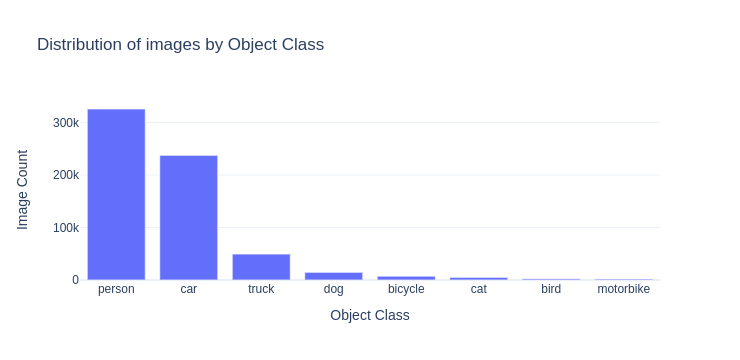

In [44]:
idx = df['date'].isin(CONFIG['DOWNTIME_DATES'])
df = df.loc[~idx]
v_counts = df['label'].value_counts().reset_index()
v_counts.columns = ['Object Class', 'Image Count']
px.bar(v_counts, y='Image Count', x='Object Class', height=300, width=500,
       title='Distribution of images by Object Class')

This picture shows a significant disproportion between the first two classes and the rest.

Based on this distribution I have decided to merge *cars* and *trucks* into a *vehicle* class and focus on predictions for person and vehicle only.

In the methodology step below I will only focus on predictions for a *Person* class, but the steps are exactly the same for *Vehicle*.

The iterative approach I took to counting objects in an hour is quite simple and works well for a dataset with a low number of objects:
- sort data by time
- divide dataset by object type (label) and perform following tasks:
- iterate through all frames containing one class (like Person or Car)
- calculate difference in time between consecutive object observations
- calculate centroid for the detected boxes
- use $x,y$ centroid coordinates to calculate an Euclidean Distance between object centroids in consecutive frames, if it's the same observation in a sequence, then the center will be close to the previous center
- keep only objects where the difference in time and distance are greater than the predefined thresholds (these have been initially set using heuristics and will change depending on the camera and its location, please see plots below for more details)

The formula to calculate the distance is the well known Pythagorean metric:

$$
d= \sqrt{(x1-x2)^2+(y1-y2)^2}
$$

The algorithm above works well with the following threshold parameters:
- `THRESH_NEW_EVENT_SECS=10` - time after which we treat another observation as unique count
- `THRESH_NEW_EVENT_MIN_DISTANCE=30` - distance in pixels between centroids

There are multiple results from this pre-processing step (one for each object class), but a sample from the *Person* dataset is provided below and it represents unique observations extracted from sequences:

In [46]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
df[['label', 'confidence', 'date', 'time', 'sec_diff', 'euc_distance']].head()

,label,confidence,date,time,sec_diff,euc_distance
0,person,0.450496,2019-09-09,07.03.03,2560.471,279.827179
1,person,0.658724,2019-09-09,07.29.50,1606.475,291.185508
2,person,0.439394,2019-09-09,08.07.56,2270.200,247.779136
3,person,0.768141,2019-09-09,08.42.40,2075.153,103.711137
4,person,0.545153,2019-09-09,08.52.30,585.361,195.661059


This dataset only contains observations for a single class label and adds a `time difference` and `eucledian distance` versus a previous image.

In [47]:
print(f'Shape of the dataset is {df.shape} (rows, cols)')

Shape of the dataset is (4790, 26) (rows, cols)


To confirm the validity of the method, below are two distributions: left one showing Euclidian Distance calculated in pixels, and right one showing difference in seconds between observations

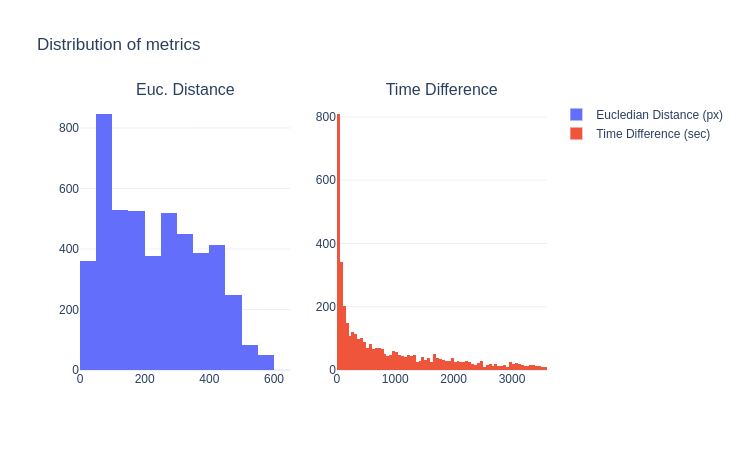

In [57]:
# initialize 2 plots in a single row
fig = make_subplots(rows=1, cols=2, subplot_titles=('Euc. Distance', 'Time Difference'))

# add euc_distance histogram
fig.add_trace(go.Histogram(x=df['euc_distance'], nbinsx=20, name='Eucledian Distance (px)'),
              row=1, col=1)

# for time difference - filter out big time differences, which would occurr during the night
fig.add_trace(go.Histogram(x=df[df['sec_diff'] < 3600]['sec_diff'], nbinsx=100,
                           name='Time Difference (sec)'), row=1, col=2)
fig.update_layout(height=350, title_text="Distribution of metrics", font=dict(size=12))
fig.show()

**Plots intepretation:**

It can be observed that there tends to be a quite wide distribution of pixel differences between objects with 50 to 100 pixels being the most probable range. The x-values in the graph make sense as the images are $608x608$ px in size.

The differences in time between objects are a little bit surprising with majority of objects being captured between 0 and 50 seconds between each other. Perhaps increasing the time between objects could be an interesting tweak to explore (I am leaving this for the future work on this project).

The implementation details and more commentary for this data transformation can be found in the [Extra Notebook 2 - ObjectCount](../Notebooks/Extra.02.ObjectCount.ipynb):

## 5.3. Further data preparation

One can very quickly notice that the majority of work in the real-life data driven/Machine Learning projects is cleaning and preparing the data.

Following this trend, the next step is to roll up the dataset to daily/hourly level.

Luckily [Pandas](https://pandas.pydata.org/) is a great tool for working with dates and has a `resample` method, which allows to aggregate the data to hourly level and fill the gaps with no observations as $0$'s.

When this is done, more time-related features can be created, like:
- `hour`
- `n_month`
- `is_weekend_day`

Below are a sample two records of the dataset after this step of data preparation with the full code is included in an [Extra Notebook 4 - Forecast](../Notebooks/Extra.04.Person-EDA-Forecast.ipynb):

In [58]:
object_detections = pd.read_parquet('../Datasets/snapshots/object_counts.parquet')
object_detections.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,day_of_week_name_short
0,2019-09-09,7,2,9,2,0,Monday,0,WeekDay
1,2019-09-09,8,3,9,2,0,Monday,0,WeekDay


## 5.4. Weather data

As an experiment I have also pulled 6 months of historical weather data to analyse if merging this data with the historical object counts can increase the prediction accuracy.

It turns out that DarkSky - one of the most popular weather applications, has an API, which can be used for free up to 1,000 requests per day (note that it does not take any new registrations due to recent acquisition by Apple).

First Pandas `date_range` function can be used to generate a range of DateTime objects with an hourly interval, which need to be converted to Unix Timestamps.

Making an API request is very simple and requires to send a `GET` HTTP request to *https://api.darksky.net/forecast* with an `API_KEY` (received during registration to the service) and a *latitude*,*longitude* of the desired location. For my hourse it is:

$$lat=51.802931199999996, long=-8.302591999999999$$

Pulling this data for six months every hour generates $4224$ data points with $24$ features and a sample few is rendered below:

In [59]:
df_weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
df_weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


The questions that are possible to answer now are:
- did it rain at 8AM on Monday?
- was there a storm last Friday at 4PM?
- what was the temperature yesterday at midday?

Full details and code to generate this dataset is located in the Notebooks folder as [Extra Notebook 3 - WeatherData](../Notebooks/Extra.03.FetchWeatherData.ipynb).

## 5.5. Exploratory data analysis (EDA)

Once the object counts data is prepared and weather data fetched, these two data sources can be combined using a common `timestamp` attribute. This merged dataset is a basis then for the further data analysis and forecasting.

**Target variable distribution**

The variable to predict is the number of object counts within an hour. 

It is expected that it is dominated by $0$'s as during the night, and often during the day, there would be many hours without any observations:

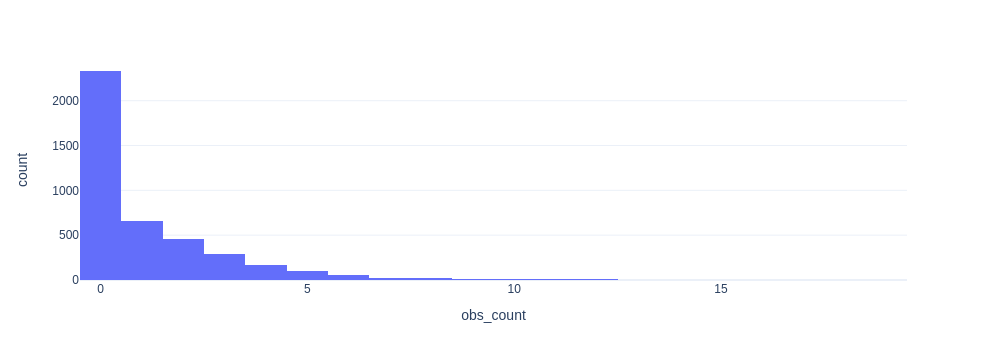

In [3]:
merged = pd.read_parquet('../Datasets/snapshots/object_counts_weather.parquet')
px.histogram(merged, x='obs_count', nbins=int(merged['obs_count'].max()) + 1,
             height=250, width=650)

The plot above shows some very high counts on the right hand side (above $count=5$). It will be very challenging to predict these numbers and only a model with a very *high variance* would be able to do that. However, as mentioned in the Literature Review (Introduction), such a model is not a good choice as it will always perform poorly on the test-data (due to memorizing of the data instead of learning the patterns.

**Missing values**

One of the benefits of manually collected dataset is that there is no missing data. However very often when one is given a dataset a decision needs to be made about the treatment of missing data (remove records, try to impute the values somehow or mark as missing).

**Outliers**

Below is the plot of weather related numerical features, where outliers will be visible:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.1. Feature Histograms</p>
<img src="../Resources/img/fcst-outliers.png" style="width: 80%;"/>

It is clearly visible that *precipitation*, *uvIndex* and *visibility* are heavily skewed and contain serious outliers.

This is bad as it can negatively affect the predictive power of the model.

The most popular method for dealing with outliers is to transform the features using one of the following transformations:
- square root - $\sqrt{x}$
- natural logarithm - $\mathcal{log}(x)$
- reciprocal transformation -$1/x$

Sometimes it is also accepted to remove observations with outliers all together, however in case of forecasting it would mean a loss of continuity in the data.

The good part of this exercise is that the Machine Learning algorithms I have tried, have produced the same results with and without these transformations, so I have decided to not transform the features, as if there are not transformed - they are easier to understand and interpret.

**Feature co-linearity**

If independant variables ($x$) are correlated with each other, it can be a problem for the statistical models. One way to analyse the effect of features on each other is to plot a correlation matrix:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.2. Feature correlation</p>
<img src="../Resources/img/corr-heatmap.png" style="width: 60%;"/>

This kind of plot can be really useful as it helps to discard features, which are too correlated and they can decrease models speed and (in terms of statistical models) decrease coefficients.

Colors show the direction of correlation (blue is negative and red positive), and the size plus opacity of the circles show the strength of the relationship.

It is clear from the graph (and makes logical sense) that `apparentTemperature` will be highly correlated with `dailyTemperature` and that `humidity` is somewhat correlated with the `cloudCover`.

## 5.6. Predicting counts

This section covers the following activities in order to predict object counts, given the available dataset:
- create a naive model (without Machine Learning) and calculate error rate
- use feature selection techniques to see which features should be included in the ML model
- train several Machine Learning models and calculate error rate
- conclude with a recommendation of the method to use going forward

### 5.6.1. Naive model

*\"All models are wrong, but some are useful\"* (Box 1976).

Starting with a naive method to generate predictions is often very useful, as the result is a baseline model, which one will try to beat with more sophisticated methods.

And even if it cannot be beaten - it can be still very useful.

**Idea**:

If we group the dataset by hour and calculate a mean of object counts - then we can convert that mean to the nearest integer and this is the most basic form of a reasonable forecast.

$$forecast(X_h)=roundInt(\frac{1}{n}\sum_{i=1}^{n}x_i)$$

, where $X_h$ is the training dataset containing all observations for a given hour $h$, and $n$ is a number of observations in that training set.

**Benefits** of this type of a basic forecast:
- easy to understand and explain
- fast to compute, requires low resources
- works for each object class without tweaking

**Downsides** of this forecast:
- it does not take into account other factors (like *weather-type* or *day-of-week*)
- it is skewed by outliers in the target variable
- it does not provide the uncertainty about the results

**Implementation**:
- split dataset into training and test sets 5 times (5-Fold Cross Validation)
- calculate mean averages for each hour
- round means to nearest integer
- calculate errors against the test-set (with cross validation):
    - mean absolute error
    - mean squared error
    - r2 score (coefficient of determination)

**Error metrics**:

$$meanAbsoluteError=\frac{1}{n}\sum_{i=1}^{n}|true-predicted|$$
$$meanSquaredError=\frac{1}{n}\sum_{i=1}^{n}(true-predicted)^2$$
$$rSquared=1-\frac{SS_{res}}{SS_{tot}}$$

, where $SS_{res}$ is the sum of squares of residuals and $SS_{tot}$ is the total sum of squares [(source)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Below are the error metrics:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.1. Error metrics - Naive model</p>

| Metric      | Person-Score |
| ----------- | ------------ |
| MSE         | 2.81         |
| MAE         | 0.94         |
| R2          | 0.27         |
| ACC         | 0.49         |

Looking at the metrics above, the errors are quite high considering that the count values are low. The R2 Score of $0.27$ is considered as a poor indicator of the predictive power, but at the same time it is not Zero also (which would mean that the model produces a random guess).

Next is the plot showing the distribution of errors made by this model (with predictions rounded to nearest integer):

<p style="text-align: center; margin-bottom: 0;">Fig. 5.3. Error distribution - Naive model</p>
<img src="../Resources/img/fcst-error-naive.png" style="width: 50%;"/>



As expected, the very high counts is where the model made big errors.

It has also overestimated a lot of values. This means that the model is biased, and in general, bias in Machine Learning is never a good symptom.

There are exceptions when for example underestimating might be much more costly than overestimating. For example in *Business Analytics* forecasting, it might be better to overestimate the demand and build some extra stock, then not being able to sell products to the customers due to over-constrained supply.

In case of this model there is no value in model overestimating or underestimating, so the goal should be as little skew as possible in the distribution of errors.

Is this model any useful? It might be a subjective answer, but I think it is.

It can be queried for an expected count at a given hour:
- 4AM - $0$
- 6AM - $0.61$, which can be rounded up to $1$
- 4PM - $2.99$, which can be rounded up to $3$

These are actually not so bad predictions, and they are quite inline with the general expectations for the current scenario.

### 5.6.2. Machine Learning

Predicting object counts can be framed as a Supervised, Machine Learning problem. The historical counts are the labels, and  other factors, like `hour`, `day-of-week`, `temperature`, `precipitation` are the input features.

The tricky nature of the target values is that they are neither purely discrete, nor continuous. They are a non-negative integers $\{0,1,2,3,4...\}$. In statistics, they are modeled as a Poisson Process, where one would estimate a so-called rate $\lambda$ of observations in a given time interval, and use a simple set of equations to answer questions like:
- Given $\lambda$ and a time interval, what is the probability of seeing next observation in the next $15$ minutes?
- Given $\lambda$, what is the probability of seeing $6$ (or any number) observations in a time interval?

This chapter includes results for the following Machine Learning models:
- Decision tree regressor
- Gradient boosted decison tree regressor
- Gaussian Process

I have also tested many other models:
- Linear Regression
- Support Vector Machines
- Feed Forward Neural Networks
- Long-Short Term Memory Recurrent Neural Networks

However, apart from a good experience in testing a broad number of Machine Learning models, I have not found them to be beneficial to this research:
- some were too simple to capture complex non-linear relationships (Linear Regression)
- some were too complex for the data volumes and much slower to train and iterate on (LTSM Neural Networks)

### 5.6.3. Feature Selection for Machine Learning

Before applying Machine Learning to the problem, there has to be a step to select the features to use. Below are the 3 methods, which I have applied:
- select K-Best using statistical test
- feature importances
- correlation matrix

**K-Best features**

The aim of this technique is to test using statistical methods the linear relationships between features and target variable. For a regression problem it uses the same method (Pearson correlation) as already explored above, where correlation matrix was printed:

$$
corr=((x - \mu_x) * (y - \mu_y)) / (\sigma_x * \sigma_y)
$$

Correlation is then transformed to an F Score, and then p-value [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html).

Below are some useful statistics to explain how it works:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.2. KBest feature selection</p>
<img src="../Resources/img/kbest.png" style="width: 50%;"/>


The statistical tests often focus on the notion of the *null hypothesis*, which is an assumption that a feature does not have a significant relationship with a target variable.

The *p-value* is a probability used to determine if the null hypothesis can be rejected (meaning there is a correlation):

$$
\begin{equation}
  f(x)=\begin{cases}
    reject, & \text{if $p<0.05$}\\
    failed\ to\ reject, & \text{otherwise}
  \end{cases}
\end{equation}
$$

Looking again at the table Tbl. 5.2., the first six features have $p<0.05$, so they do influence the count of objects, where the last column (`pearson_corr`) determines the strength and direction of the correlation.

Plot below shows a jointplot between the best feature `cur__uvIndex` and `obs_count` (for $800$ samples, which is $25\%$ of the training dataset):

<p style="text-align: center; margin-bottom: 0;">Fig. 5.4. KBest jointplot</p>
<img src="../Resources/img/btest-jointplot1.png" style="width: 40%;"/>

Since the Pearson correlation between the UV-Index and count of observations is positive ($0.331$), then it means that the count of observations increases linearly when UV-Index increases.

Looking at all the correlations between all features and the target variable shows a following picture:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.5. KBest - correlations with Target Variable</p>
<img src="../Resources/img/kbest-corr-all.png" style="width: 70%;"/>

**Drawbacks**:

While it is always adviced to verify the relationships between variables, the approach above assumes that they are linear and in the real-life datasets this assumption very often crumbles. On top of this, there might be some weak dependancies betwen the features as well, which may be difficult to deal with. As a rule of thumb, features should not be discarded too easily.

As usual, detail implementation, more techniques and additional commentary for the plots above can be found in the [Extra Notebook 4](../Notebooks/Extra.04.Person-EDA-Forecast.ipynb).

### 5.6.4. Decision Tree

Decison Trees are one of the most basic and easy to interpret ML models. They do not require data scaling, and can be used for both: Data Analysis and Machine Learning (classification and regression).

The theoretical aspect of Decision Trees has been covered in the [Literature Review Chapter](../Chapters/02.LiteratureReview.ipynb), but in a nutshell model searches the best features and then values to split the nodes in the tree into two groups separating the impact on the Target Variable.

When trained on the Person object counts dataset, as expected, the algorithm chose to split the dataset by *UV-Index* in the root node, and then by *hour* and *temperature*. This can be observed in the vizualisation below:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.6. Decision tree - nodes</p>
<img src="../Resources/img/tree.png" style="width: 55%;"/>

Below are the results achieved from running a 5-fold Cross Validation on this model:

| Metric      | Person-Score |
| ----------- | ------------ |
| MSE         | 2.73         |
| MAE         | 0.92         |
| R2          | 0.29         |
| ACC         | 0.53         |

This is already a an improvement over the naive model, which had the $R2\ Score=2.24$.

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.7. Decision tree - error distribution</p>
<img src="../Resources/img/fsct-errors-dt.png" style="width: 60%;"/>

The error distribution looks much more even, which means that the model is not as biased as the Naive model.

### 5.6.5. Gradient Boosting Regressor Tree

The next step is to extend a Decision Tree model to a more powerful one.

Gradient Boosting Trees use more advanced mathematically technique to use the gradient of a loss function (like mean squared error) to find optimal parameters to reduce the errors.

The implememtation in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) is designed to work well with larger datasets and generalise better, as it does not have to search across all feature values to find the best value to spit it, but creates $N-bins$ instead.

This model, cross validated across $5$ folds with hyperparameters estimated using a GridSearch across $12000$ models is capable of achieving the following results:

| Metric      | Person-Score |
| ----------- | ------------ |
| MSE         | 2.47         |
| MAE         | 0.87         |
| R2          | 0.36         |
| ACC         | 0.54         |

Looking at the R2 Score, this model achieves a much better performance and scores a respectible $R2\ Score=0.36$.

**Benefits**:

Because of the fact that this model uses gradients and multiple passes, there is an opportunity to see how the error decreases on the training and testing sets. This is something always used in the Neural Networks approach, but not so often in the Sci-kit Learn framework models.

The model runs very fast, considering how much computation is happening behond the scenes.

This regressor also allows to use a Possion loss function, which is the most suitable loss for the count datasets (please refer to the [Literature Review Chapter](../Chapters/02.LiteratureReview.ipynb) for the theory and application of the Poisson distribution.

The plot below shows a good convergence after 400 iterations (validation curve is flattening) and there are no signs of overfitting (validation curve is not increasing):

<p style="text-align: center; margin-bottom: 10px;">Fig. 5.8. Loss curve - Gradient Based Decision Tree</p>
<img src="../Resources/img/loss-curve-gbdt.png" style="width: 70%;"/>

**Drawbacks**:

The drawback to this model is that it is not so easy any more to interpret the trees generated inside the algorithm and that it is a much more complex model than the simple Decision Tree model. Obviously this can also be seen as a benefit, as it is a much more powerful model.

The predictions from the model are point estimate, which means that this model does not return the uncertainty about the results, so it is difficult to understand where model was confident and not confident in the generated outputs.

**Error Distribution**:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.9. Error distribution - Gradient Based Decision Tree</p>
<img src="../Resources/img/fcst-errors-gbdt.png" style="width: 80%;"/>

Similar to vanilla Decision Tree model, the errors are distributed quite evenly (with a little higher peak at $error=-1$), which is a good sign of not biased model.

### 5.6.5. Gaussian Process

<a id="conclusion"></a>
## 5.7. Conclusion

- Show error distributions for all models
- All models very robust
- Stitch all tables above into a one single table showing all the stats
- Include a note for the Vehicle class as well and mention error rates achieved with teh same model.
- Leave question for future work: how much data do we need to be accurate (1,2,3 weeks ... 6 months)

[index](../Index.ipynb) | [prev](./04.DataCollection.ipynb) | [next](./06.AnomalyDetection.ipynb)